# **PREDICT CUSTOMERS' NUMBER OF CLUSTER**

#### Import necessary libraries

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import squarify
import plotly.express as px
import plotly as py
import plotly.graph_objs as go
import datetime as dt
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
from plotly.subplots import make_subplots
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, boxcox
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [2]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd

#### Loading dataset

In [3]:
# data
sales_df_raw = pd.read_excel('AdventureWorks Sales_raw.xlsx', sheet_name='Sales_data')

date_df_raw = pd.read_excel('AdventureWorks Sales_raw.xlsx', sheet_name='Date_data')

product_df_raw= pd.read_excel('AdventureWorks Sales_raw.xlsx', sheet_name='Product_data')

customer_df_raw = pd.read_excel('AdventureWorks Sales_raw.xlsx', sheet_name='Customer_data')

In [4]:
sales_df = sales_df_raw[['SalesOrderLineKey','CustomerKey','ProductKey','OrderDateKey','Order Quantity','Sales Amount']]
sales_df.shape

(121253, 6)

In [5]:
product_df = product_df_raw[['ProductKey','Product','Model','Subcategory','Category']]
product_df = product_df[product_df['Category'] == 'Bikes']
product_df.shape

(125, 5)

In [6]:
#keep columns DateKey, Date
date_df = date_df_raw[['DateKey','Date']]
date_df = date_df.rename(columns={'DateKey': 'OrderDateKey'})
date_df.shape

(1461, 2)

In [7]:
#delete value -1 of CustomerKey and columns Postal Code and Customer ID
customer_df_raw = customer_df_raw[customer_df_raw['CustomerKey'] != -1]
customer_df_raw = customer_df_raw[customer_df_raw['Country-Region'] == 'United States']
customer_df = customer_df_raw.drop(columns=['Postal Code','Customer ID'])

customer_df.shape

(7819, 5)

#### Data Engineering
create the dataframe for RFM model

In [8]:
aw_df = pd.merge(left=sales_df, right=product_df,on='ProductKey')
aw_df = pd.merge(left=aw_df, right=date_df, on='OrderDateKey')
aw_df = pd.merge(left=aw_df, right=customer_df, on='CustomerKey')

aw_df.head()

,SalesOrderLineKey,CustomerKey,ProductKey,OrderDateKey,Order Quantity,Sales Amount,Product,Model,Subcategory,Category,Date,Customer,City,State-Province,Country-Region
0,43711001,27606,314,20170702,1,3578.27,"Road-150 Red, 56",Road-150,Road Bikes,Bikes,2017-07-02,Courtney Edwards,Milwaukie,Oregon,United States
1,71134001,27606,563,20200421,1,2384.07,"Touring-1000 Yellow, 54",Touring-1000,Touring Bikes,Bikes,2020-04-21,Courtney Edwards,Milwaukie,Oregon,United States
2,43706001,27621,312,20170702,1,3578.27,"Road-150 Red, 48",Road-150,Road Bikes,Bikes,2017-07-02,Edward Brown,Santa Monica,California,United States
3,71203001,27621,561,20200422,1,2384.07,"Touring-1000 Yellow, 46",Touring-1000,Touring Bikes,Bikes,2020-04-22,Edward Brown,Santa Monica,California,United States
4,43707001,27616,312,20170702,1,3578.27,"Road-150 Red, 48",Road-150,Road Bikes,Bikes,2017-07-02,Emma Brown,Lemon Grove,California,United States


In [9]:
aw_df = aw_df.dropna()
aw_df.isnull().sum()

SalesOrderLineKey    0
CustomerKey          0
ProductKey           0
OrderDateKey         0
Order Quantity       0
Sales Amount         0
Product              0
Model                0
Subcategory          0
Category             0
Date                 0
Customer             0
City                 0
State-Province       0
Country-Region       0
dtype: int64

In [10]:
aw_df=aw_df.drop_duplicates()

## RFM analysis

In [11]:
recent_day = aw_df['Date'].max()
min_day = aw_df['Date'].min()
min_day, recent_day

(Timestamp('2017-07-01 00:00:00'), Timestamp('2020-05-30 00:00:00'))

Days 1064
Years, Months, Days
2, 10, 29

---

In [12]:
df_rfm = aw_df.groupby(by='CustomerKey', as_index=False).agg(
    {
        'Date': lambda r: (recent_day - r.max()).days,
        'SalesOrderLineKey': lambda f: f.nunique(),
        'Sales Amount': lambda m: m.sum()
    }
)

df_rfm.columns = ['Customer ID','Recency','Frequency','Monetary']
df_rfm.head().style.background_gradient(cmap='YlGn')

,Customer ID,Recency,Frequency,Monetary
0,11015,344,1,2319.990000
1,11016,322,1,2294.990000
2,11021,339,1,2294.990000
3,11022,342,1,2319.990000
4,11036,340,1,2319.990000


In [13]:
df_rfm['R score'] = pd.qcut(df_rfm['Recency'], 5, labels=[5,4,3,2,1])
df_rfm['F score'] = pd.qcut(df_rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
df_rfm['M score'] = pd.qcut(df_rfm['Monetary'], 5, labels=[1,2,3,4,5])

df_rfm['RFM'] = df_rfm['R score'].astype(str) + df_rfm['F score'].astype(str) + df_rfm['M score'].astype(str)

df_rfm


,Customer ID,Recency,Frequency,Monetary,R score,F score,M score,RFM
0,11015,344,1,2319.99,1,1,3,113
1,11016,322,1,2294.99,1,1,3,113
2,11021,339,1,2294.99,1,1,3,113
3,11022,342,1,2319.99,1,1,3,113
4,11036,340,1,2319.99,1,1,3,113
...,...,...,...,...,...,...,...,...
3564,29334,867,1,3578.27,1,4,4,144
3565,29335,866,1,3578.27,1,4,4,144
3566,29350,866,1,3578.27,1,4,4,144
3567,29352,873,1,3578.27,1,4,4,144


## Data Preprocessing

In [14]:
rfm_table = df_rfm.drop(columns=['R score','F score','M score','RFM','Customer ID'])
rfm_table.describe()

,Recency,Frequency,Monetary
count,3569.000000,3569.000000,3569.000000
mean,204.569627,1.374895,2521.675408
std,212.433617,0.489918,1665.622903
min,0.000000,1.000000,539.990000
25%,67.000000,1.000000,1120.490000
50%,159.000000,1.000000,2294.990000
75%,260.000000,2.000000,3578.270000
max,1062.000000,3.000000,6640.610000


In [15]:
attributes = ['Recency','Frequency','Monetary']

In [16]:
for i in rfm_table[attributes]:
    # ---------------------Finding the IQR---------------------------
    q1 = rfm_table[i].quantile(0.25)
    q3 = rfm_table[i].quantile(0.75)
    # ----------------Finding upper and lower limit------------------
    iqr = q3 - q1
    upper_limit = q3 + 1.5 * iqr
    lower_limit = q1 - 1.5 * iqr
    # # ------------------------Finding Outliers----------------------------
    rfm_table.loc[rfm_table[i] > upper_limit,i] = upper_limit
    rfm_table.loc[rfm_table[i] < lower_limit,i] = lower_limit
# # ---------------------------------Trimming------------------------------------
rfm_table = rfm_table[rfm_table[['Recency','Frequency', 'Monetary']] < upper_limit]
rfm_table = rfm_table.dropna(axis=0)
rfm_table

,Recency,Frequency,Monetary
0,344.0,1.0,2319.99
1,322.0,1.0,2294.99
2,339.0,1.0,2294.99
3,342.0,1.0,2319.99
4,340.0,1.0,2319.99
...,...,...,...
3564,549.5,1.0,3578.27
3565,549.5,1.0,3578.27
3566,549.5,1.0,3578.27
3567,549.5,1.0,3578.27


## Data Transformation

only take positive value because boxcox transformation data required positive data

In [17]:
rfm_normal = rfm_table.copy()
rfm_normal = rfm_normal[rfm_normal['Recency']>0]

In [18]:
# Transformation process to get the skewness close to 0
# Log transformation
rfm_log = rfm_normal.copy()
rfm_log = np.log(rfm_log[['Recency','Frequency','Monetary']])
# Square root transformation
rfm_sqrt = rfm_normal.copy()
rfm_sqrt = np.sqrt(rfm_sqrt[['Recency','Frequency','Monetary']])
# Cube root transformation
rfm_cbrt = rfm_normal.copy()
rfm_cbrt = np.cbrt(rfm_cbrt[['Recency','Frequency','Monetary']])
# Box cox transformation
rfm_boxcox = rfm_normal.copy()

#boxcox require 1-dimension data
rfm_boxcox['Recency'] = boxcox(rfm_boxcox['Recency'])[0]
rfm_boxcox['Frequency'] = boxcox(rfm_boxcox['Frequency'])[0]
rfm_boxcox['Monetary'] = boxcox(rfm_boxcox['Monetary'])[0]

## Data Normalization

#### scaling the RFM data

In [19]:
standard_scaler = StandardScaler()
rfm_scaled = rfm_boxcox[['Recency', 'Frequency', 'Monetary']].values
rfm_scaled = standard_scaler.fit_transform(rfm_boxcox)
rfm_scaled = pd.DataFrame(rfm_scaled)
rfm_scaled.columns = ['Recency','Frequency','Monetary']

rfm_scaled.head(10).style.background_gradient('YlGn')

,Recency,Frequency,Monetary
0,1.122264,-0.769798,0.131878
1,1.020114,-0.769798,0.116775
2,1.099396,-0.769798,0.116775
3,1.113141,-0.769798,0.131878
4,1.103986,-0.769798,0.131878
5,0.755649,-0.769798,0.131878
6,1.140416,-0.769798,0.116775
7,-0.690856,1.296262,0.534548
8,1.126813,-0.769798,0.116775
9,1.171886,-0.769798,0.116775


## K-Means

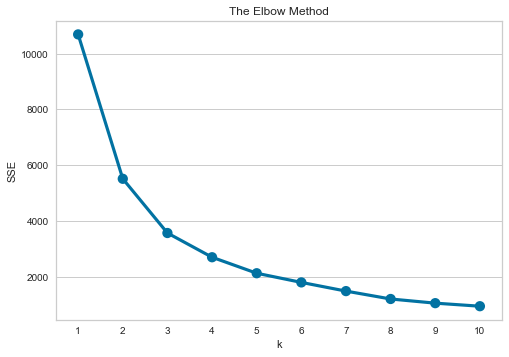

In [20]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_ 
    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Elbow method results is 3

In [21]:
model = KMeans(n_clusters=3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
model.fit(rfm_scaled.values)

KMeans(n_clusters=3, random_state=0)

The centroids of the K clusters, which can be used to label new data

Labels for the training data (each data point is assigned to a single cluster)

In [22]:
rfm_scaled['Cluster'] = model.labels_
rfm_scaled.head()

,Recency,Frequency,Monetary,Cluster
0,1.122264,-0.769798,0.131878,2
1,1.020114,-0.769798,0.116775,2
2,1.099396,-0.769798,0.116775,2
3,1.113141,-0.769798,0.131878,2
4,1.103986,-0.769798,0.131878,2


In [23]:
rfm_scaled.groupby('Cluster').agg(
    {
        'Recency':'mean',
        'Frequency':'mean',
        'Monetary':'mean'
    }
).round(2).T

Cluster,0,1,2
Recency,-0.90,-0.07,0.94
Frequency,-0.76,1.30,-0.77
Monetary,-0.67,0.88,-0.37


Distribution Of The Clusters

In [24]:
rfm_normal['Cluster'] = model.labels_
rfm_normal.head()

,Recency,Frequency,Monetary,Cluster
0,344.0,1.0,2319.99,2
1,322.0,1.0,2294.99,2
2,339.0,1.0,2294.99,2
3,342.0,1.0,2319.99,2
4,340.0,1.0,2319.99,2


| Cluster| Recency | Frequency | Monetary | Value |
| ----------- | ----------- | ----------- | ----------- |----------- |
| 0   | Low |Low |Low |Low value customers |
| 1   | Low |High|High |High value customers |
| 2   | High |Low |Low |Mid value customers |


---
---

In [25]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor  # import decision tree classifier
from sklearn.model_selection import train_test_split  # import train_test_split function
from sklearn import metrics  # import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import stats

In [26]:
feature_columns = ['Recency', 'Frequency', 'Monetary']
cluster_names = ['0', '1', '2']

In [27]:
print(feature_columns)
X = rfm_normal[feature_columns]
y = rfm_normal['Cluster']

['Recency', 'Frequency', 'Monetary']


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training and 30% test

In [59]:
X_train, X_test, y_train, y_test

(      Recency  Frequency   Monetary
 1165    240.0        1.0  1700.9900
 1976    102.0        1.0  1120.4900
 1863    227.0        1.0  2443.3500
 1919    365.0        1.0  1700.9900
 945      93.0        2.0  3102.9800
 ...       ...        ...        ...
 1131    261.0        1.0  1700.9900
 1295     41.0        1.0  2319.9900
 861      11.0        2.0  1552.4800
 3513    549.5        1.0  3578.2700
 3180     63.0        2.0  4433.1682
 
 [2494 rows x 3 columns],
       Recency  Frequency  Monetary
 2276    168.0        1.0    539.99
 184     288.0        2.0   5873.26
 2730    232.0        1.0   2384.07
 1362     51.0        1.0   2319.99
 2861    206.0        2.0   5759.06
 ...       ...        ...       ...
 3546    102.0        2.0   4320.62
 2019     68.0        1.0   1120.49
 1559     27.0        1.0   2319.99
 2933    141.0        2.0   5759.06
 2526     48.0        1.0    539.99
 
 [1069 rows x 3 columns],
 1165    2
 1976    0
 1863    2
 1919    2
 945     1
        ..
 1

In [29]:
def regressionmodel(model,X_train, X_test,y_train,y_test):
    model=model.fit(X_train,y_train)#Fitting train data for order quantity
    y_pred=model.predict(X_test)#predicting sales with test data
    print('Model parameter used are:',model) #Printing the model to see which parameters are used
    #Printing mean absolute error for predicting sales
    print("MAE is         :", metrics.mean_absolute_error(y_test,y_pred))
    print("RMSE is        :",np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

# Decision tree

In [30]:
clf_tree=DecisionTreeClassifier(random_state=0)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [31]:
train_score = clf_tree.score(X_train.values, y_train.values)
print('Decision Tree score on train data:', train_score)
test_score = clf_tree.score(X_test.values, y_test.values)
print('Decision Tree score on test data:', test_score)

Decision Tree score on train data: 1.0
Decision Tree score on test data: 0.9990645463049579


In [32]:
# Which features are the most important in model?
feature_importance=pd.DataFrame({'importance':clf_tree.feature_importances_, 'feature':feature_columns})
feature_importance.sort_values(by='importance', ascending=False).reset_index(drop=True)

,importance,feature
0,0.515824,Frequency
1,0.455859,Recency
2,0.028317,Monetary


(-1.1095704106804407,
 1.1004557352964428,
 -1.1098118375633943,
 1.125339813174985)

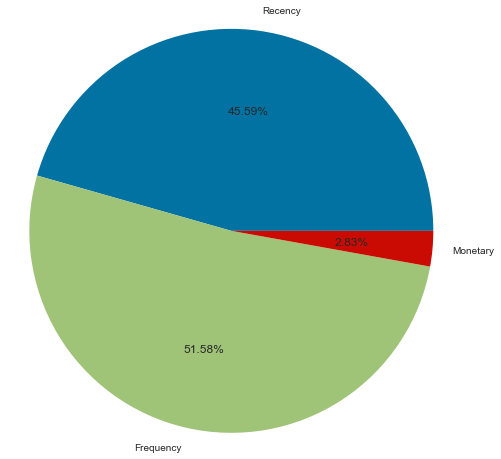

In [33]:
# Which features are the most important in model?
fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(feature_importance['importance'], labels=feature_importance['feature'], autopct='%1.2f%%')
ax1.axis('equal')

In [34]:
from sklearn.model_selection import GridSearchCV

finding optimal parameters using GridSearchCV

In [35]:
# Parameter optimization
parameters = {'criterion': ['entropy', 'gini'],
              'max_depth': np.arange(1,clf_tree.tree_.max_depth+1),
              'max_features':np.arange(1, clf_tree.max_features_+1)
             }
clf = GridSearchCV(DecisionTreeClassifier(), param_grid=parameters)
clf.fit(X_train, y_train)
print("Best criterion parameter: ", clf.best_params_['criterion'])
print("Best max_depth parameter: ", clf.best_params_['max_depth'])
print("Best max_features parameter: ", clf.best_params_['max_features'])

Best criterion parameter:  gini
Best max_depth parameter:  6
Best max_features parameter:  3


In [36]:
clf_tree = DecisionTreeClassifier(criterion='gini', max_depth=6, max_features=3, random_state=42)
clf_tree = clf_tree.fit(X_train,y_train)
gini_pred = clf_tree.predict(X_test)

In [58]:
print("Accuracy score: ", metrics.accuracy_score(y_test, gini_pred))

regressionmodel(clf_tree,X_train,X_test,y_train,y_test)

Accuracy score:  0.9990645463049579
Model parameter used are: DecisionTreeClassifier(max_depth=6, max_features=3, random_state=42)
MAE is         : 0.0018709073900841909
RMSE is        : 0.06117037502066161


In [56]:
print(confusion_matrix(y_test, gini_pred)) 
  
print(classification_report(y_test, gini_pred)) 

[[320   0   1]
 [  0 423   0]
 [  0   0 325]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       321
           1       1.00      1.00      1.00       423
           2       1.00      1.00      1.00       325

    accuracy                           1.00      1069
   macro avg       1.00      1.00      1.00      1069
weighted avg       1.00      1.00      1.00      1069



In [39]:
from sklearn import tree


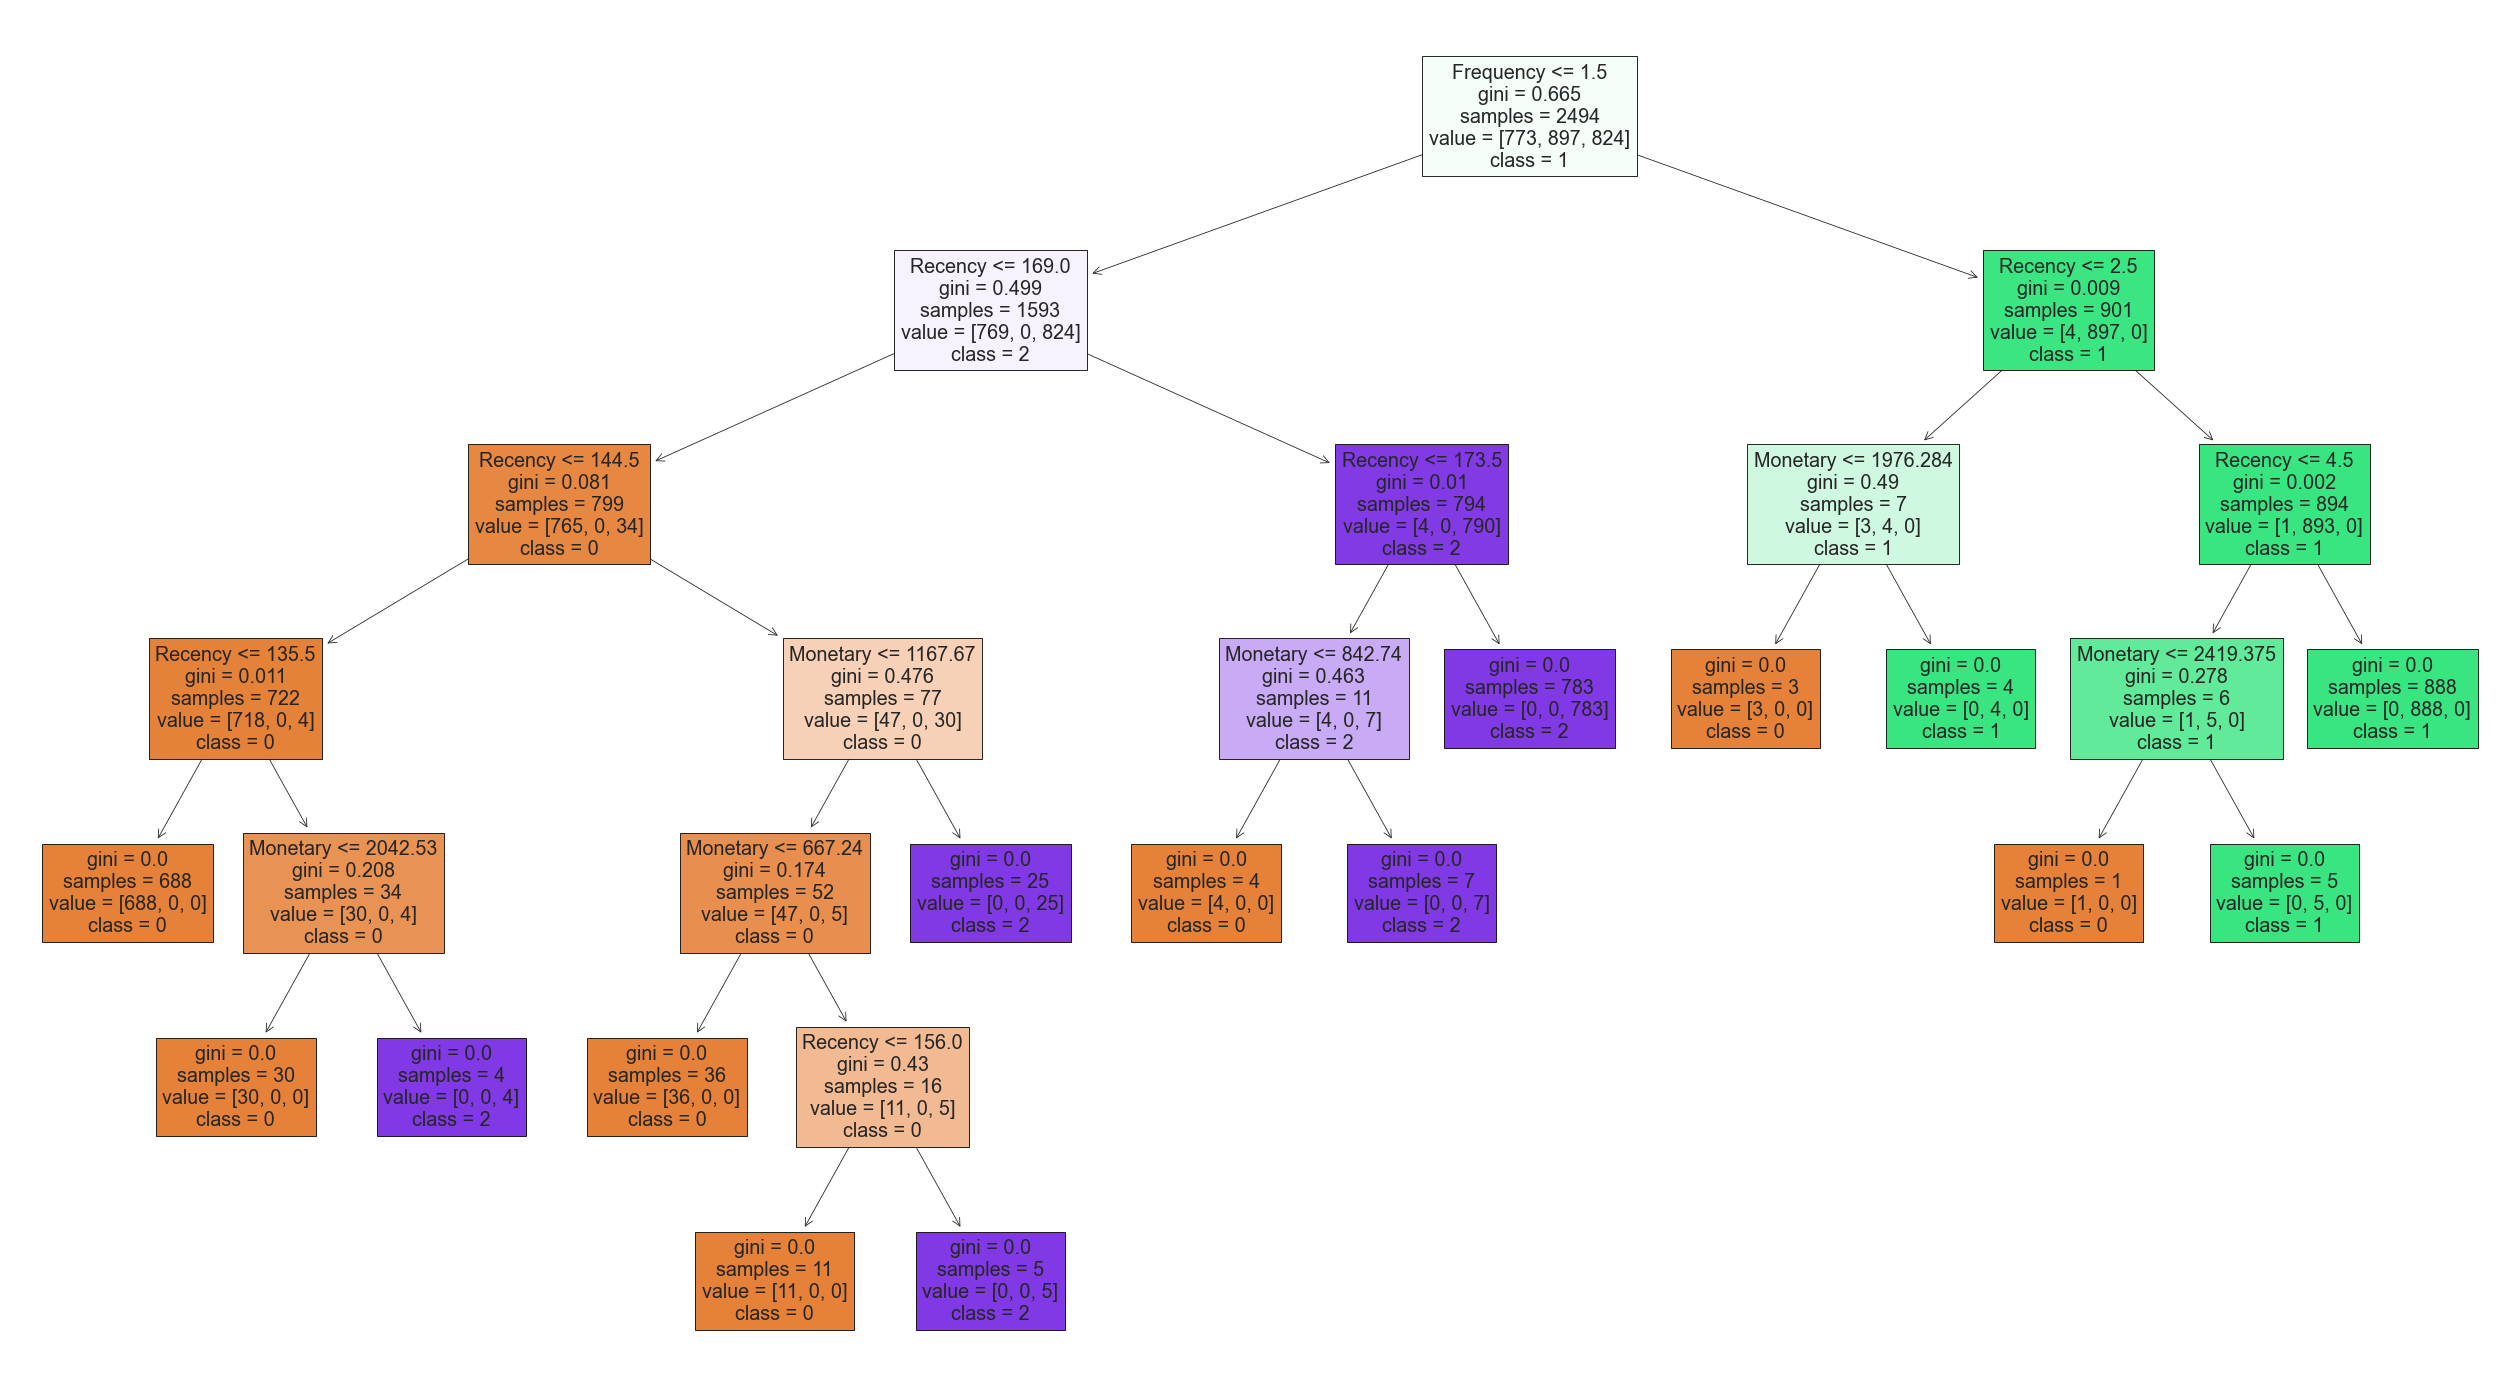

In [40]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (16,9), dpi=200)
tree.plot_tree(clf_tree,
               feature_names = feature_columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()

In [41]:
from sklearn.tree import _tree

In [42]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [43]:
rule_values = get_rules(clf_tree, feature_columns, cluster_names)
rule_values

['if (Frequency > 1.5) and (Recency > 2.5) and (Recency > 4.5) then class: 1 (proba: 100.0%) | based on 888 samples',
 'if (Frequency <= 1.5) and (Recency > 169.0) and (Recency > 173.5) then class: 2 (proba: 100.0%) | based on 783 samples',
 'if (Frequency <= 1.5) and (Recency <= 169.0) and (Recency <= 144.5) and (Recency <= 135.5) then class: 0 (proba: 100.0%) | based on 688 samples',
 'if (Frequency <= 1.5) and (Recency <= 169.0) and (Recency > 144.5) and (Monetary <= 1167.67) and (Monetary <= 667.24) then class: 0 (proba: 100.0%) | based on 36 samples',
 'if (Frequency <= 1.5) and (Recency <= 169.0) and (Recency <= 144.5) and (Recency > 135.5) and (Monetary <= 2042.53) then class: 0 (proba: 100.0%) | based on 30 samples',
 'if (Frequency <= 1.5) and (Recency <= 169.0) and (Recency > 144.5) and (Monetary > 1167.67) then class: 2 (proba: 100.0%) | based on 25 samples',
 'if (Frequency <= 1.5) and (Recency <= 169.0) and (Recency > 144.5) and (Monetary <= 1167.67) and (Monetary > 667.24

# Linear Regression

In [44]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [45]:
lr.fit(X_train.values, y_train.values)

LinearRegression()

In [46]:
train_score = lr.score(X_train.values, y_train.values)
print('Regressor score on train data:', train_score)
test_score = lr.score(X_test.values, y_test.values)
print('Regressor score on test data:', test_score)

Regressor score on train data: 0.5285717305457521
Regressor score on test data: 0.5253361596462358


In [47]:
y_pred = lr.predict(X_test)

In [53]:
regressionmodel(lr,X_train,X_test,y_train,y_test)

Model parameter used are: LinearRegression()
MAE is         : 0.47077768206041265
RMSE is        : 0.5355690227775272
